# Advanced Model Building
In this example we'll examine the different ways one can go about building models in LUMIN, as well as how some of the more advanced block modules can be used.

We'll use the data from the Binary_Classification example, so you'll need to run through that first.

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

In [2]:
from pathlib import Path
PATH = Path('data/')

## Data import
These objects get created during the Binary_Classification example.

In [3]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feats = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [4]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


## Model Building API approaches

A full network in LUMIN is constructed from three sub-modules:
- A `head` which takes in input features and applies any requested initial processing to them, e.g. entity embedding for categorical features
- A `body` which contains the hidden layers and performs most of the computation
- And a `tail` which downscales the output of the `body` to the reqested number of outputs and applies the final activation function on the network output

Normal usage of LUMIN expects to train a non-fixed number of models, so instead of creating models and training them, we instead specify how models should be created and use the `ModelBuilder` class to construct models on demand.

`ModelBuilder` has `model_args`, `head`, `body`, and `tail` parameters. The `head`, `body`, and `tail` parameters are used to set the block classes which are used for each block. By default they are:
- `CatEmbHead` - which provides categorical entity embedding for categorical inputs, parsing of continuous inputs, and separate Dropout rates for embedded and continuous inputs.
- `FullyConnected` - which provides a series of dense layers of variable width, dropout, batch normalisation, activation functions, as well as options for additative (ResNet-like) and concatination (DenseNet-like) skip connections.
- `ClassRegMulti` - which provides a single dense output layer with a suitable activation function.

Control of the various parameters of these blocks can be done in two ways:
1. `model_args` can be set to a dictionary of dictionaries of the form `{'head':{head_args},'body':{body_args},'tail':{tail_args}}`. These arguments are then passed to the relevant blocks when the network is built
1. the individual block parameters of `ModelBuilder` can be set to partial functions which when called will return a class with the desired parameters, e.g. body=partial(FullyConnected, width=100, depth=4)

### model_args approach
Let's look at the simplest approach where we specify block parameters in `model_args`. Note that since we don't specify parameters for the head block, `ModelBuilder` will add an empty dictionary automatically.

In [31]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder

bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':100, 'depth':4},
              'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", len(cont_feats), " continuous features:", [var for var in cont_feats])
print("\nTraining on", len(cat_feats), " categorical features:", [var for var in cat_feats])
print('\n Model:')
print(Model(model_builder))


Training on 30  continuous features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_met_pt']

Training on 1  categorical features: ['PRI_jet_num']

 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swish()
      )
      (1): Sequential(
   

### Partial approach
Now let's look at a fully `partial`-based approach

In [32]:
from functools import partial
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

body = partial(FullyConnected, depth=4, width=100, act='swish')
tail = partial(ClassRegMulti, bias_init=np.mean(train_fy.get_column('targets')))

model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             body=body, tail=tail, opt_args=opt_args)

print('\n Model:')
print(Model(model_builder))


 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (3): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
    )
  )
  (2): ClassRegMulti(
    (dense): Linear(in_features=100, out_features=1, bias=True)
    (act): Sigmoid()
  )
)>
                   

Number of trainable parameters: 33709
                   

Optimiser:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
 

### model_args + partial hybrid approach
We can even use a mixture of `partial` and argument specification for different parts of the network

In [34]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder
from functools import partial
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

model_args = {'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}
body = partial(FullyConnected, depth=4, width=100, act='swish')

model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)

print('\n Model:')
print(Model(model_builder))


 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (3): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
    )
  )
  (2): ClassRegMulti(
    (dense): Linear(in_features=100, out_features=1, bias=True)
    (act): Sigmoid()
  )
)>
                   

Number of trainable parameters: 33709
                   

Optimiser:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
 

## Advanced Model Building

### MultiBlock Body
The default body block `FullyConnected` treats all outputs of the head block as the same and passes them all through dense layers together, however we may have features which we want to treat differently. E.g. in particle physics we have low-level features, which could be a raw representation of the collision (e.g. final-state 4-momenta), however we commonly compute several high-level features, which are theory inspired non-linear combinations of low-level features.

In the example data we have both high (`DER_`) and low (`PRI_`) features, which we may want to try treating differently; perhaps the low-level features might require a deeper network to learn a useful representation for them, whereas the high-level features might simply require a single layer. See e.g [Wide-Deep Models](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)

Using the `MultiBlock` body we can define a sets of features and a corresponding series of `FullyConnected` objects. Because `ClassRegMulti` takes in named features and provides a maping of feature names to its outputs, we can specify subsets of named featured to `MultiBlock`'s `feats_per_block` parameter in order to pass the correct features though each sub-body block which are defined as partials in the `blocks` parameter.

In [37]:
model.head.feat_map

{'DER_mass_MMC': [0],
 'DER_mass_transverse_met_lep': [1],
 'DER_mass_vis': [2],
 'DER_pt_h': [3],
 'DER_deltaeta_jet_jet': [4],
 'DER_mass_jet_jet': [5],
 'DER_prodeta_jet_jet': [6],
 'DER_deltar_tau_lep': [7],
 'DER_pt_tot': [8],
 'DER_sum_pt': [9],
 'DER_pt_ratio_lep_tau': [10],
 'DER_met_phi_centrality': [11],
 'DER_lep_eta_centrality': [12],
 'PRI_met_sumet': [13],
 'PRI_jet_all_pt': [14],
 'PRI_lep_px': [15],
 'PRI_lep_py': [16],
 'PRI_lep_pz': [17],
 'PRI_jet_subleading_px': [18],
 'PRI_jet_subleading_py': [19],
 'PRI_jet_subleading_pz': [20],
 'PRI_tau_px': [21],
 'PRI_tau_py': [22],
 'PRI_tau_pz': [23],
 'PRI_jet_leading_px': [24],
 'PRI_jet_leading_py': [25],
 'PRI_jet_leading_pz': [26],
 'PRI_met_px': [27],
 'PRI_met_py': [28],
 'PRI_met_pt': [29],
 'PRI_jet_num': [30, 31]}

To start, we'll send the high-level features through a single wide layer, and both the high and low level features through a deep network

In [39]:
from lumin.nn.models.blocks.body import MultiBlock

hl_feats = [f for f in train_feats if 'DER_' in f]
ll_feats = [f for f in train_feats if 'PRI_' in f]

model_args = {'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}

body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=33, act='swish', dense=True)],
               feats_per_block=[hl_feats,train_feats])

model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)

print('\n Model:')
print(Model(model_builder))


 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=13, out_features=50, bias=True)
            (1): Swish()
          )
        )
      )
      (1): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=32, out_features=33, bias=True)
            (1): Swish()
          )
          (1): Sequential(
            (0): Linear(in_features=65, out_features=33, bias=True)
            (1): Swish()
          )
          (2): Sequential(
            (0): Linear(in_features=98, out_features=33, bias=True)
            (1): Swish()
          )
          (3): Sequential(
            (0): Linear(in_features=131, out_features=33, bias=True)
            (1): Swish()
          )
          (4): Se

Maybe it would be possible to get away only sending the low-level features though the deep network, however it is likely that some interaction between low- and high-level features will be beneficial. We can use the `bottleneck_sz` and `bottleneck_act` parameters to create extra bottleneck layers. There will be one per sub-body block which will take in all the features which its corresponding block does not use, pass them through a narrow dense layer (and optionally an activation function) and concatinate its output to the other input features before they are passed though the block. Effectively, the block now sees both its specified input features and a highly compressed representation of all features it would otherwise not use. Hopefully this should allow the features to be split, whilst still allowing some interaction between the features witout the number of free-parameters in the model becoming too great.

In [40]:
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=24, act='swish', dense=True)],
               feats_per_block=[hl_feats,ll_feats],
               bottleneck_sz=5, bottleneck_act='swish')

model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)

print('\n Model:')
print(Model(model_builder))


 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (bottleneck_blocks): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=19, out_features=5, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=13, out_features=5, bias=True)
        (1): Swish()
      )
    )
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=18, out_features=50, bias=True)
            (1): Swish()
          )
        )
      )
      (1): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=24, out_features=24, bias=True)
            (1): Swish()
          )
          (1): Sequential(
            (0): Linear(in_features=48, out_features=24, bias=True)
            (1): Swish()
          )
         

#### Interpretation
Splitting the computation of features allows us to also better interpret the model once its trained. In this example we have a single output neuron, which will take as inputs the row-wise concatination of the tensors computed by the `MultiBlock` body. For an example input we can compute then the dot product of the output neuron's weights corresponding to each sub-body block with the outputs of each sub-body block. By repeating this for many example inputs we can see the overall reliance of the output layer on the different blocks, and in so doing the overall reliance of the model on the different sets of input features.

To test this, lets remove the bottleneck layers so the outputs of each sub-body block only depend on the either the low- or high-level features

In [41]:
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=19, act='swish', dense=True)],
               feats_per_block=[hl_feats,ll_feats])

model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)

print('\n Model:')
print(Model(model_builder))


 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=13, out_features=50, bias=True)
            (1): Swish()
          )
        )
      )
      (1): FullyConnected(
        (layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=19, out_features=19, bias=True)
            (1): Swish()
          )
          (1): Sequential(
            (0): Linear(in_features=38, out_features=19, bias=True)
            (1): Swish()
          )
          (2): Sequential(
            (0): Linear(in_features=57, out_features=19, bias=True)
            (1): Swish()
          )
          (3): Sequential(
            (0): Linear(in_features=76, out_features=19, bias=True)
            (1): Swish()
          )
          (4): Seq

We now want to train a single model

LR finder took 4.881s 


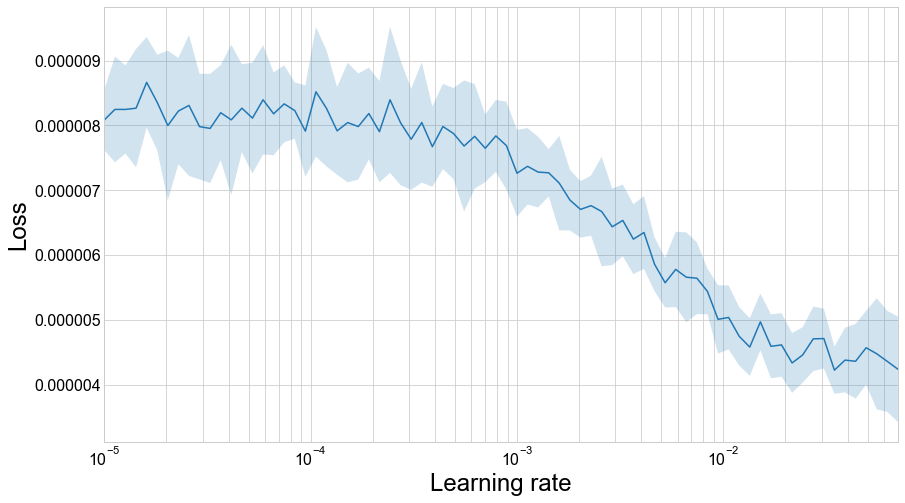

In [42]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [43]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import AMS

callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2])]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_orig_weight')}

Training model 1 / 1, Val ID = 0


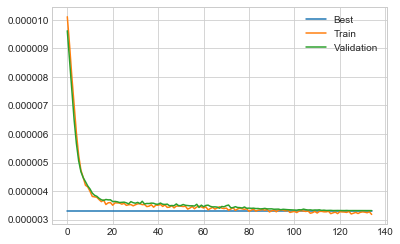

Early stopping after 135 epochs
Scores are: {'loss': 3.3152196010632906e-06, 'AMS': 3.734600059819256}
Fold took 77.822s


______________________________________
Training finished
Cross-validation took 77.826s 


<Figure size 432x288 with 0 Axes>

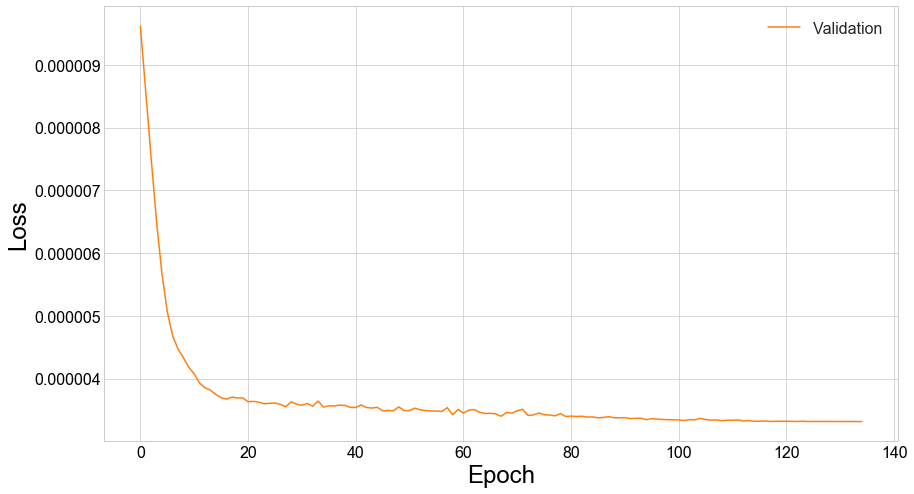

Mean loss = 3.3152196010632906e-06±0.0
Mean AMS = 3.734600059819256±0.0
______________________________________



<Figure size 432x288 with 0 Axes>

In [44]:
from lumin.nn.training.fold_train import fold_train_ensemble

results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models=1,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=15)

In [25]:
model = Model.from_save('train_weights/train_0.h5', model_builder)

Having loaded our trained model, lets pass a fold of training data though it, record the inputs to the tail block, and then compute the absolute values of the dot products of the weights with the inputs coming from each sub-body block. We can show the general trend for the data as a box-and-whisker diagram

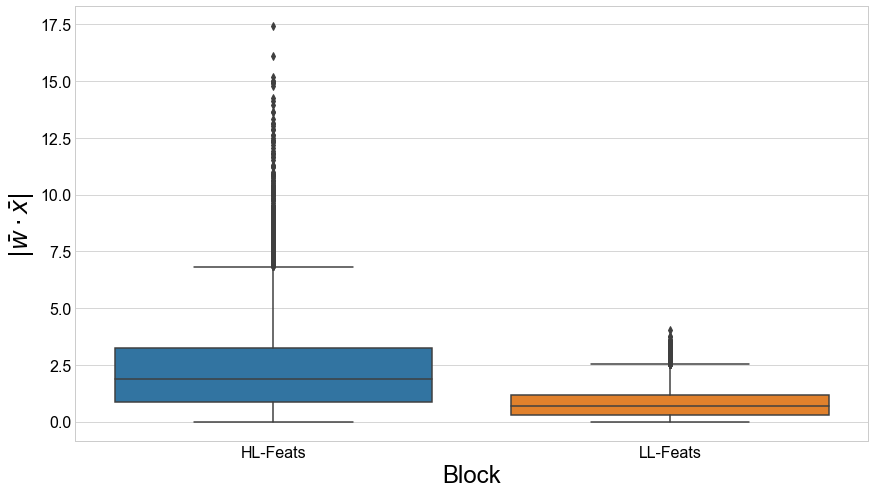

In [46]:
from lumin.plotting.interpretation import plot_multibody_weighted_outputs

plot_multibody_weighted_outputs(model=model, inputs=train_fy[1]['inputs'], block_names=['HL-Feats', 'LL-Feats'])

So overall it seems then the high-level features have the greatest influence on the final output of our model , which seems to be in agreement with what we find when computing the individual permutation importance of the features

Top ten most important features:
                        Feature  Importance  Uncertainty
0                 DER_mass_vis    0.620210     0.033681
1           DER_deltar_tau_lep    0.580867     0.016462
2                 DER_mass_MMC    0.228459     0.013870
3  DER_mass_transverse_met_lep    0.222220     0.008265
4                   DER_sum_pt    0.219977     0.009822
5         DER_pt_ratio_lep_tau    0.218671     0.013391
6                   PRI_met_pt    0.093177     0.005891
7                   PRI_tau_px    0.089878     0.004959
8                   PRI_tau_py    0.085457     0.007263
9                   PRI_lep_px    0.075821     0.003769


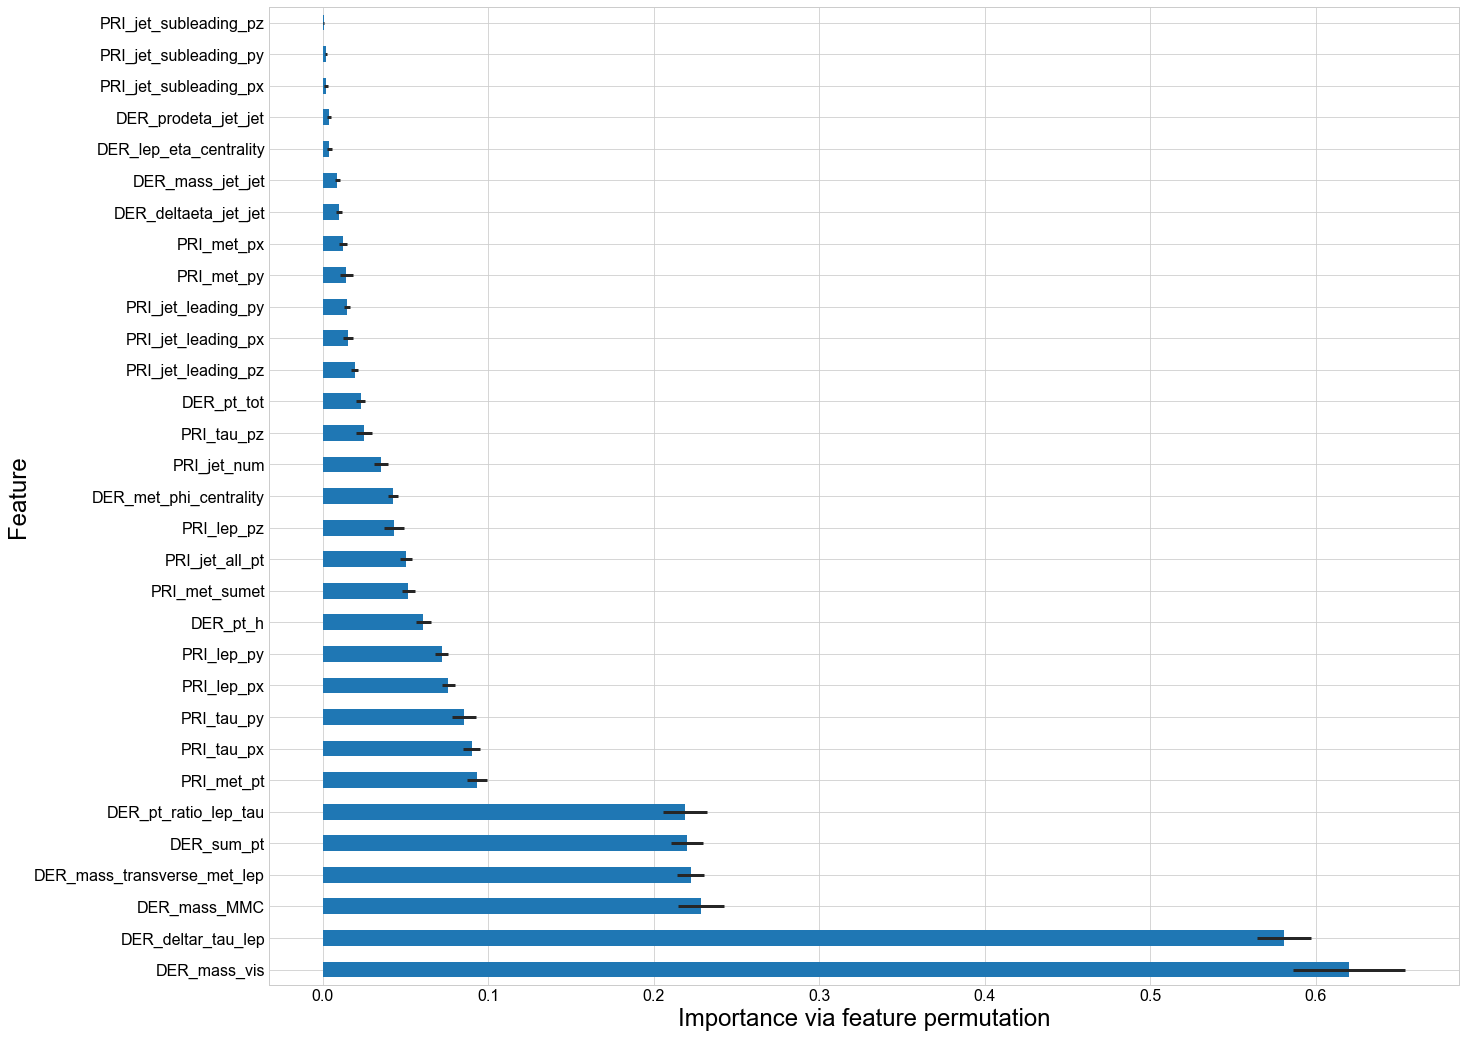

In [47]:
_ = model.get_feat_importance(train_fy)